# IV Calculation 

## For call options

### BS Model

$C=\Phi(d_1)S - \Phi(d_2)Ke^{-rt}$ \
$P = \Phi(-d_2)Ke^{-rt} - \Phi(-d_1)S$ \
$d_1 = \frac{1}{\sigma \sqrt(t)}[log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t]$ \
$d_2 = d_1 - \sigma \sqrt(t) $


Say we have observed a call price $C_0$ \
and we are looking for a value $\sigma$, such that \
$\Phi(d_1)S - \Phi(d_2)Ke^{-rt} - C_0 = 0$


note that we need a derivative of C w.r.t $\sigma$ \
$\nu = \frac{\partial C}{\partial \sigma} = S \phi(d_1)\sqrt{t}$

We will use Newton's method(see Appendix)

In [1]:
from numpy import sqrt, exp, log, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime as dt
import warnings
#from scipy.interpolate import griddata
import plotly.graph_objects as go
from arch import arch_model
import nbformat
%matplotlib inline

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

### Black-Scholes formula, for a call option

In [3]:
def option_price(sigma, S, K, r, t,type = "c"):
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    C = np.multiply(S, norm.cdf(d1)) - \
        np.multiply(norm.cdf(d2) * K, np.exp(-r * t))
    P = np.multiply(norm.cdf(-d2) * K, np.exp(-r * t)) - \
        np.multiply(S,norm.cdf(-d1))
    if type == "c":
        return C
    elif type == "p":
        return P
    else:
        print("You must specify the type correctly (c or p)!!!")
    

### Objective function used for optimization

In [4]:
def objective_function(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    price = args[4]
    
    return option_price(sigma, S, K, r, t) - price

### Vega calculation

In [5]:
def calculate_vega(sigma, args):
    S = args[0]
    K = args[1]
    r = args[2]
    t = args[3]
    
    d1 = np.multiply( 1. / sigma * np.divide(1., np.sqrt(t)),
        np.log(S/K) + (r + sigma**2 / 2.) * t  )
    d2 = d1 - sigma * np.sqrt(t)
    
    return S * norm.pdf(d1) * np.sqrt(t)

### Newton's method

In [6]:
def newtons_method(f, fprime, R = 0, max_iter = 1000, tol=1e-3, args = [], debug = False):
    try:
        # Convert warnings to exceptions
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)
            count = 0
            epsilon = 1
    
            while epsilon >= tol:
                count += 1
                if count >= max_iter:
                    print('Forced exit, the loop runs away')
                    return (R, count)
        
                old_R = R
        
                function_value = f(R, args = args)
                function_derivative = fprime(R, args = args)
        
               
                R = -function_value / function_derivative + R
        
                epsilon = np.abs( (R - old_R) / old_R)
                if debug == True:
                    print('Iteration = ', count, 'f = ', function_value, 'fprime = ', function_derivative, 'Tol = ', epsilon)
        
            return R
    except RuntimeWarning:
        # Handle RuntimeWarnings here
        return None
    except Exception:
        # Handle all other exceptions here
        return 6969

# Get real data

#### Function to fetch data for options

#### We need:
1) option price c0
2) spot price S
3) strike price K
4) interest rate r
5) time to expiration t

In [7]:
def options_data(ticker,option_type = "call",oi_lower_bound=0):
    asset = yf.Ticker(ticker)
    exp_dates = asset.options #expiration dates for options
    data = pd.DataFrame() #dataframe for keeping of downloaded options
    for exp in exp_dates:
        options = asset.option_chain(exp)
        calls = options.calls
        calls["optionType"] = "call"
        puts = options.puts
        puts["optionType"] = "put"
        d = pd.concat([calls,puts])
        d["expiration"] = pd.to_datetime(exp)+pd.DateOffset(hours=23,minutes=59,seconds=59)
        data = pd.concat([data,d])
    data["dte"] = (data["expiration"] - dt.datetime.today()).dt.days + 1
    data = data[["strike","lastPrice","volume","openInterest","optionType","dte","impliedVolatility"]]
    data = data[data["openInterest"]>oi_lower_bound]
    if option_type == "call":
        call_chain = data[data["optionType"] == "call"]
        return call_chain
    elif option_type == "put":
        put_chain = data[data["optionType"] == "call"]
        return put_chain
    else:
        return data


### Example for AAPL

In [57]:
aapl_c = options_data("AAPL",oi_lower_bound=0)

In [58]:
aapl_c.head()

,strike,lastPrice,volume,openInterest,optionType,dte,impliedVolatility
8,45.0,184.23,34.0,45.0,call,5,17.378911
12,65.0,176.50,2.0,485.0,call,5,9.214848
88,365.0,0.01,95.0,1219.0,call,5,0.500005
89,370.0,0.01,3.0,673.0,call,5,1.156254
6,40.0,189.16,1.0,2.0,call,68,0.000010


In [59]:
S_aapl = yf.download("AAPL")["Close"].iloc[-1].iat[-1]
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [60]:
r_1y

np.float64(0.04212999820709228)

### Calculation of implied volatility for aapl_c dataframe

In [61]:
aapl_c["iv"] = aapl_c.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_aapl,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

#### A test with fixed arguemnts

In [62]:
S = S_aapl                   #  Index price
K = 250.0             #  Strike price
r = r_1y                      #  Risk-free rate
t = 3.0/365.0                    #  Time until expiration
C0 = 0.05      #  Call price taken to be the midprice between the bid and ask

args = (S, K, r, t, C0)  
newtons_method(objective_function,calculate_vega,0.5,args=args) 

np.float64(0.29136863216468023)

### Surface plot

In [63]:
aapl_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 8 to 7
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   strike             51 non-null     float64
 1   lastPrice          51 non-null     float64
 2   volume             43 non-null     float64
 3   openInterest       51 non-null     float64
 4   optionType         51 non-null     object 
 5   dte                51 non-null     int64  
 6   impliedVolatility  51 non-null     float64
 7   iv                 8 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.6+ KB


In [69]:
aapl_c.head(30)

,strike,lastPrice,volume,openInterest,optionType,dte,impliedVolatility,iv
8,45.0,184.23,34.0,45.0,call,5,17.378911,NaN
12,65.0,176.50,2.0,485.0,call,5,9.214848,NaN
88,365.0,0.01,95.0,1219.0,call,5,0.500005,NaN
89,370.0,0.01,3.0,673.0,call,5,1.156254,NaN
6,40.0,189.16,1.0,2.0,call,68,0.000010,NaN
13,75.0,160.88,10.0,23.0,call,68,3.305910,NaN
15,85.0,163.70,1.0,196.0,call,68,1.169926,NaN
3,45.0,177.77,1.0,1.0,call,159,2.129643,NaN
7,65.0,160.07,2.0,212.0,call,159,0.000010,NaN
8,70.0,174.83,13.0,403.0,call,159,1.617311,NaN


In [64]:
aapl_c_ = aapl_c.dropna()

In [65]:
def plot_iv_values(data):
    x = data['strike'].values
    y = data['dte'].values
    z = data['iv'].values

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c=z, cmap='viridis')

    ax.set_xlabel('Strike prices')
    ax.set_ylabel('DTE (Days to Expiration)')
    ax.set_zlabel('IV (Implied Volatility)')

    ax.set_title('IV of the stock')

    plt.show()


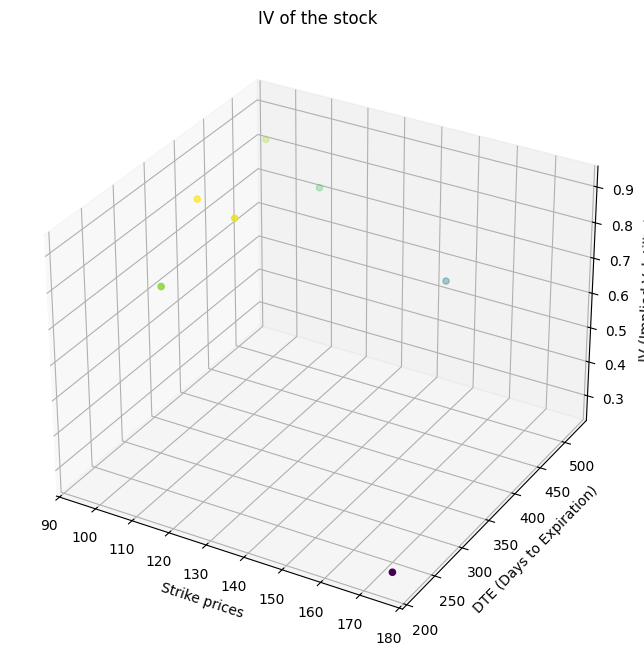

In [66]:
x = aapl_c_['strike'].values
y = aapl_c_['dte'].values
z = aapl_c_['iv'].values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c=z, cmap='viridis')

ax.set_xlabel('Strike prices')
ax.set_ylabel('DTE (Days to Expiration)')
ax.set_zlabel('IV (Implied Volatility)')

ax.set_title('IV of the stock')

plt.show()

# Interactive Plot

In [17]:
def plot_iv_values_inter(d):
    fig3 = go.Figure(
        data=[
            go.Scatter3d(
                x=aapl_c_["strike"],  # X-axis
                y=aapl_c_["dte"],     # Y-axis
                z=aapl_c_["iv"],      # Z-axis
                mode='markers',
                marker=dict(
                    size=5,
                    color=aapl_c_["iv"],  # Color by "iv" values
                    colorscale='Viridis',  # Color scale
                    opacity=0.8
                )
            )
        ]
    )

# Customize layout
    fig3.update_layout(
        title="Interactive 3D Scatter Plot",
        scene=dict(
            xaxis_title="Strike",
            yaxis_title="DTE",
            zaxis_title="IV"
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

# Show the plot
    return fig3.show()

In [18]:
fig3 = go.Figure(
    data=[
        go.Scatter3d(
            x=aapl_c_["strike"],  # X-axis
            y=aapl_c_["dte"],     # Y-axis
            z=aapl_c_["iv"],      # Z-axis
            mode='markers',
            marker=dict(
                size=5,
                color=aapl_c_["iv"],  # Color by "iv" values
                colorscale='Viridis',  # Color scale
                opacity=0.8
            )
        )
    ]
)

# Customize layout
fig3.update_layout(
    title="Interactive 3D Scatter Plot",
    scene=dict(
        xaxis_title="Strike",
        yaxis_title="DTE",
        zaxis_title="IV"
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig3.show()

## Alternatively, as a surface

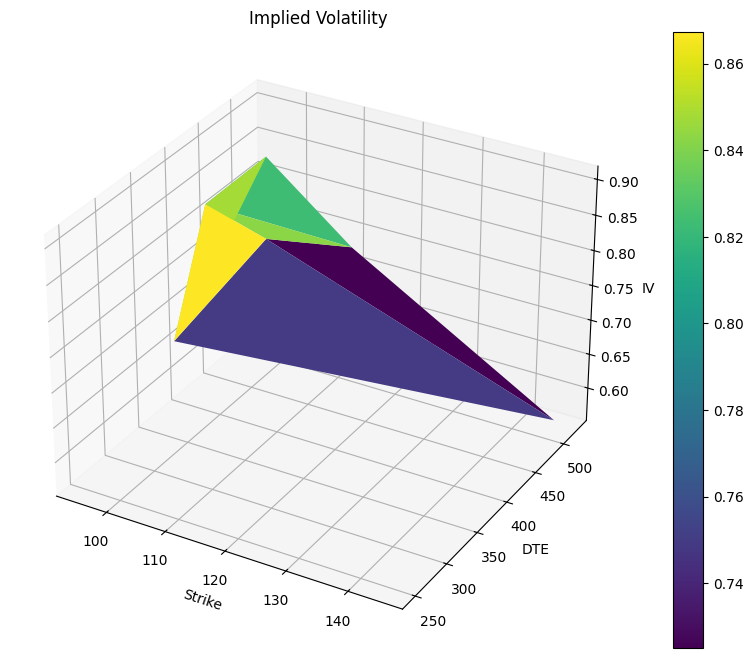

In [19]:
fig2 = plt.figure(figsize=(12,8))

ax2 = fig2.add_subplot(111,projection = "3d")

surf = ax2.plot_trisurf(x,y,z,cmap = "viridis")

ax2.set_xlabel("Strike")
ax2.set_ylabel("DTE")
ax2.set_zlabel("IV")

ax2.set_title("Implied Volatility")
fig2.colorbar(surf)
plt.show()

### Volatility Measures

#### Historical Volatility

In [20]:
def hist_vol(ticker,window):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close
    log_ret = np.log(ticker_data/ticker_data.shift())
    hist_vol = (log_ret.rolling(window).std().dropna())*np.sqrt(252)
    last_30_values = hist_vol[-30:]
    last_value = round(hist_vol.iloc[-1,-1],4)
    print(f"The last value of historical volatility based on {window}-day window is {last_value}")

    fig,ax = plt.subplots(figsize = (14,6))
    ax.plot(last_30_values,label = "Line Plot",color = "black")
    ax.set_title(f"{window}-day historical volatility values (annualized)",fontsize = 20)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return plt.show(fig)

[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 30-day window is 0.1843


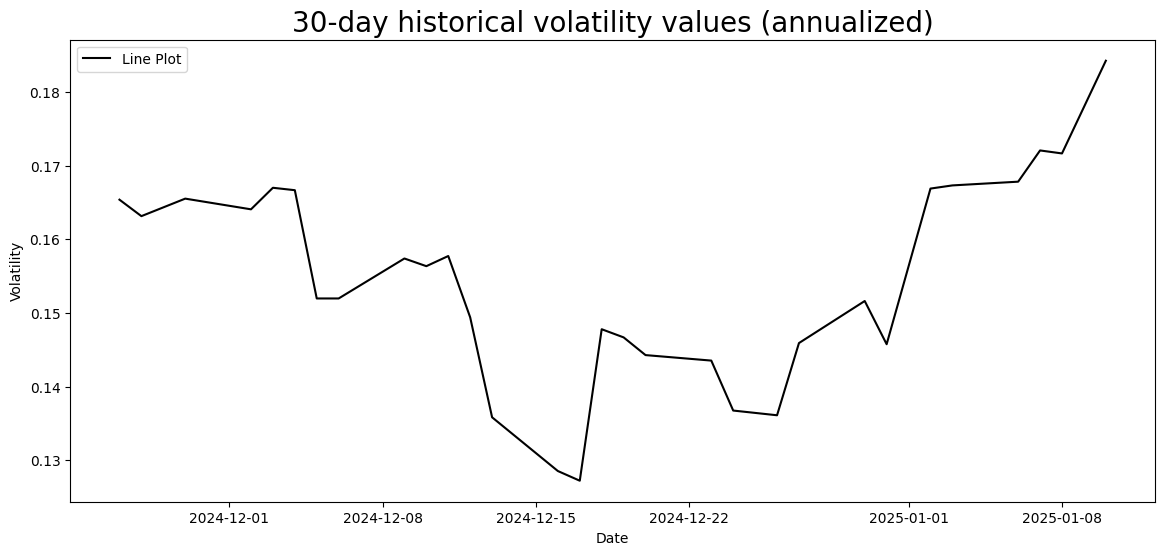

In [21]:
hist_vol("AAPL",30)

#### EWMA volatility

In [22]:
ticker_data = yf.download("AAPL").Close
ticker_data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
1980-12-12,0.098834
1980-12-15,0.093678
1980-12-16,0.086802
1980-12-17,0.088951
1980-12-18,0.091530


In [23]:
lmbd = 0.94
def ewma(ticker):
    ticker_data = yf.download(ticker)
    ticker_data = ticker_data.Close
    log_ret = np.log(ticker_data/ticker_data.shift())
    hist_vol = (log_ret.rolling(window).std().dropna())*np.sqrt(252)

In [24]:
k = yf.download("AAPL").Close[-100:]
k = k.to_numpy().flatten()

[*********************100%***********************]  1 of 1 completed


#### GARCH Conditional Volatility

Fit and plot of conditional volatility based on GARCH(1,1):

One-step-ahead forecast of GARCH-conditional volatility

In [26]:
ticker_data = yf.download("AAPL").Close
ret = np.log(ticker_data/ticker_data.shift()).dropna()
window = 1000
model = arch_model(ret[-window:],p=1,q=1)
model_fit = model.fit(disp = "off")
pred = model_fit.forecast(horizon=3)
np.sqrt(pred.variance.values)*np.sqrt(252)


[*********************100%***********************]  1 of 1 completed
/Users/matyassvehla/Desktop/Options/Volatility Surface/iv_surface/.iv_calc/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




array([[0.22347005, 0.2243743 , 0.22525693]])

In [27]:
rolling_predictions = []
test_size = 365
for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train,p=3,q=0)
    model_fit = model.fit(disp = "off")
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_predictions = pd.Series(rolling_predictions,index=returns.index[-365:])

NameError: name 'returns' is not defined

### Greeks

In [28]:
r = 0.01
S = 30
K = 40
t = 240/365
sigma = 0.3

In [29]:
option_price

<function __main__.option_price(sigma, S, K, r, t, type='c')>

In [30]:
option_price(sigma,S,K,r,t,type = "c")

np.float64(0.5132843798399414)

#### Delta

$delta = \frac{\partial P}{\partial S}$ \
$delta(call) = \Phi(d_1)$ > 0 \
$delta(put) = -\Phi(-d_1) < 0$

In [31]:
def delta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    if type == "c":
        delta_value = norm.cdf(d1)
    elif type == "p":
        delta_value = - norm.cdf(-d1)
    return delta_value

#### Gamma

$Gamma = \frac{\partial Delta}{\partial S^2}$ 

$Gamma = \frac{\phi(d_1)}{S\sigma\sqrt{t}}$

In [32]:
def gamma(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    gamma_value = (norm.pdf(d1))/(S*sigma*np.sqrt(t))
    return gamma_value

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ 

We have already defined vega, function: calculate_vega 

- it was neccessary(as an input for the Newton's algortihm), since it is a derivative of the option price w.r.t. $\sigma$
- function name: calculate_vega

In [33]:
calculate_vega

<function __main__.calculate_vega(sigma, args)>

#### Theta

$Theta = - \frac{\partial P}{\partial t}$ 

call: $Theta = -\frac{S \phi(d_1)\sigma}{2t} - rKexp(-rt)\Phi(d_2)$

put: $Theta = -\frac{S \phi(d_1)\sigma}{2t} + rKexp(-rt)\Phi(-d_2)$

In [34]:
def theta(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) - r*K*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        theta_value = ((-S*norm.pdf(d1)*sigma)/(2*t)) + r*K*np.exp(-r*t)*norm.cdf(-d2)
    return theta_value/365 #to obtain time decay per day, not years

### Rho

$Rho = \frac{\partial P}{\partial r}$

call: $Rho = KTexp(-rt)\Phi(d_2) > 0$ 

 put: $Rho = -KTexp(-rt)\Phi(-d_2) < 0$ 

In [35]:
def rho(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    if type == "c":
        rho_value = K*t*np.exp(-r*t)*norm.cdf(d2)
    elif type == "p":
        rho_value = -K*t*np.exp(-r*t)*norm.cdf(-d2)
    return rho_value*0.01 #to obtain sensitivity to 1% change in rates

### Vega

$Vega = \frac{\partial P}{\partial \sigma}$ \
$Vega = S \phi(d_1) \sqrt{t}$

In [36]:
def vega(sigma, S, K, r, t,type = "c"):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    vega_value = S*norm.pdf(d1,0,1)*np.sqrt(t)
    return vega_value
    


In [37]:
greek_fun = {"delta":delta,
                 "gamma":gamma,
                 "rho":rho,
                 "theta":theta,
                 "vega":vega}
def greeks(sigma, S, K, r, t,type):
    result = {name: func(sigma, S, K, r, t,type) for name,func in greek_fun.items()}
    return pd.DataFrame([result]).reset_index(drop=True)

# Final Screen

Function: hist_vol \
Insert a ticker and a length of a window to obtain values for historical volatility for the last month:

[*********************100%***********************]  1 of 1 completed

The last value of historical volatility based on 60-day window is 0.174


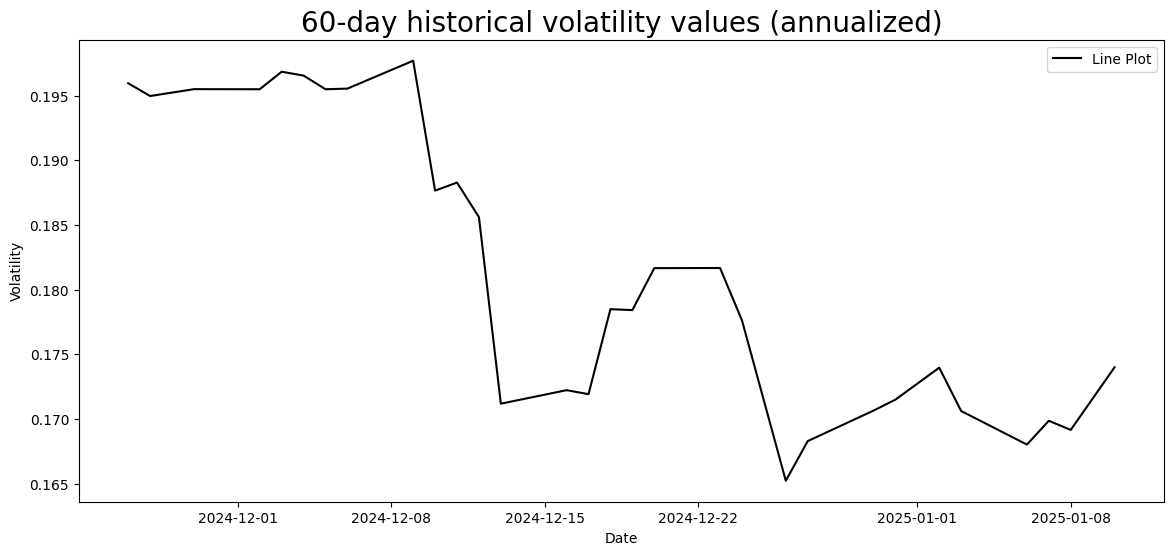

In [38]:
hist_vol("AAPL",60)

Function: greeks \
Insert volatility, spot price, strike price, interest rate, time (years) to expiration and type of the option(c = call, p = put) \
Obtain a data frame with option greeks: delta, gamma, rho, theta, vega

In [39]:
greeks(sigma= 0.2,S = 100,K = 100,r = 0.05,t = 10/365,type = "c")

,delta,gamma,rho,theta,vega
0,0.523099,0.120309,0.013951,-0.405249,6.592268


Function: options_data \
Insert a ticker, required option type, lower bound for open interest in given options(excludes scarcely traded options, with open interest being below the given lower bound)

In [70]:
ticker = "AAPL" #Input the required ticker
option_type = "call" #The calculation is adapted for call options
oi_lower_bound = 0 #Input the required lower bound of the open interest

In [71]:
S_ticker = yf.download(ticker)["Close"].iloc[-1].iat[-1] #The last closing price for the given ticker
r_1y = yf.download("^IRX")["Close"].iloc[-1].iat[-1]/100 #Interest rate for the calculation, based on US-Treasury 1-year yield

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [72]:
data_options = options_data(ticker,option_type,oi_lower_bound).dropna()
data_options["iv"] = data_options.apply(lambda row: newtons_method(objective_function,calculate_vega,0.5,
                                                       args=(S_ticker,row["strike"],r_1y,float(row["dte"]/365),row["lastPrice"])),axis = 1)

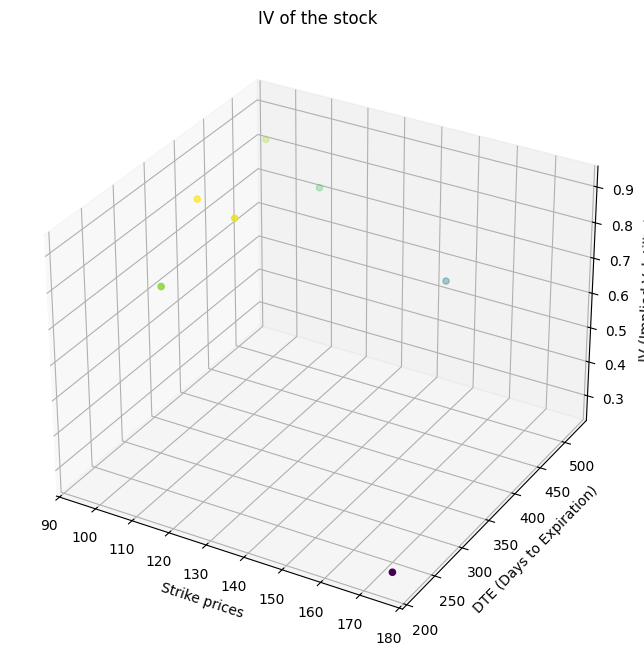

In [73]:
plot_iv_values(data_options)

In [74]:
plot_iv_values_inter(data_options)

To do:
1) GARCH fitted vol for the last month and predictions
2) add an option to add lines to the plots, e.g. S, and volatilities
3) spend some time with the graphical side of those plots...